In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.svm import SVC
from mpl_toolkits import mplot3d
from sklearn.cluster import DBSCAN
from xgboost import XGBClassifier

### 1.1 The Data and 1.2 Handling Bad Entries

In [2]:
imgatt_path = 'C:/Users/isabe/Documents/term_3/ai/Assignments/Project2/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt'
imglabels_path = 'C:/Users/isabe/Documents/term_3/ai/Assignments/Project2/CUB_200_2011/CUB_200_2011/image_class_labels.txt'

In [3]:
# reading image_attribute_labels.txt but this time only the first 3 columns
imgatt = pd.read_csv(imgatt_path, delimiter='\s+', usecols=[0,1,2], on_bad_lines='skip', names=['imgid', 'attid', 'present'])

# image_class_labels.txt
imglabels = pd.read_csv(imglabels_path, delimiter='\s+', on_bad_lines='skip', names=['imgid', 'classid'])

In [4]:
# outputting file heads
print('imgatt \n',imgatt.head())
print('imglabels \n',imglabels.head())

imgatt 
    imgid  attid  present
0      1      1        0
1      1      2        0
2      1      3        0
3      1      4        0
4      1      5        1
imglabels 
    imgid  classid
0      1        1
1      2        1
2      3        1
3      4        1
4      5        1


In [5]:
#displays no nulls or strange data types
print(imgatt.describe())
print('--------------------------------')
print(imglabels.describe())
print('--------------------------------')
print(imgatt.info())
print('--------------------------------')
print(imglabels.info())

              imgid         attid       present
count  3.677856e+06  3.677856e+06  3.677856e+06
mean   5.894500e+03  1.565000e+02  1.008868e-01
std    3.402903e+03  9.006619e+01  3.011788e-01
min    1.000000e+00  1.000000e+00  0.000000e+00
25%    2.947750e+03  7.875000e+01  0.000000e+00
50%    5.894500e+03  1.565000e+02  0.000000e+00
75%    8.841250e+03  2.342500e+02  0.000000e+00
max    1.178800e+04  3.120000e+02  1.000000e+00
--------------------------------
              imgid       classid
count  11788.000000  11788.000000
mean    5894.500000    101.126315
std     3403.046821     57.476826
min        1.000000      1.000000
25%     2947.750000     51.000000
50%     5894.500000    101.000000
75%     8841.250000    151.000000
max    11788.000000    200.000000
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677856 entries, 0 to 3677855
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   imgid    int64
 1   attid    int64
 2  

In [6]:
# outputting file shapes
print('imgatt shape:', imgatt.shape)
print('imglabels shape', imglabels.shape)

imgatt shape: (3677856, 3)
imglabels shape (11788, 2)


<b> Discuss Contents In Detail </b><br>
<b> imgatt: </b> 3677856 rows and 3 columns. A dataset of attributes belonging to each image. The loaded columns refer to a specific image of a bird (imgid), an attribute the image may or many not have (attid), and whether or not that attribute is present (present)<br>
<b> imglabels: </b> 11788 rows and 2 columns. A dataset refering to a specific image of a bird (imgid) and its true class of bird (classid)<br>

### 1.3 Data Transformation

In [7]:
# getting rid of duplicates in imgatt before transforming from long to wide
imgatt_nodupes = imgatt.drop_duplicates()

#pivot method
imgatt2 = imgatt_nodupes.pivot(index='imgid', columns='attid')

In [8]:
# new head with rows and columns
imgatt2.head()

present                                      ...                      \
attid     1   2   3   4   5   6   7   8   9   10   ... 303 304 305 306 307   
imgid                                              ...                       
1           0   0   0   0   1   0   0   0   0   0  ...   0   0   0   0   0   
2           0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
3           0   0   0   0   1   0   0   0   0   0  ...   0   0   0   0   0   
4           0   0   0   0   1   0   0   0   0   0  ...   0   0   0   1   0   
5           0   0   0   0   1   0   0   0   0   0  ...   0   0   1   0   0   

                           
attid 308 309 310 311 312  
imgid                      
1       1   0   0   0   0  
2       0   0   0   0   0  
3       1   0   0   1   0  
4       0   1   0   0   0  
5       0   0   0   0   0  

[5 rows x 312 columns]

In [9]:
# shape
imgatt2.shape

(11788, 312)

When presented as a pivot table, the data has 11788 rows (images) and 312 columns (attributes). The 'present' value indicates whether or not that attribute is present.

### 1.4 Data Merging and Shuffle

In [10]:
# set imagelabels index to imgid
imglabels2 = imglabels.set_index('imgid')

# merging the two datasets
imgattlabels = pd.concat([imgatt2, imglabels2], axis=1)

#shuffling
imgattlabels = imgattlabels.sample(frac=1, random_state=10)

In [11]:
# splitting into attributes and labels
attributes = imgattlabels.iloc[:,:-1]
labels = imgattlabels.iloc[:,-1]

#convert to numpy arrays
attributes = attributes.to_numpy()
labels = labels.to_numpy()

#labels are already flattened
print(labels.shape)

(11788,)


### 2 Training and Testing Sets

In [12]:
#splitting into training and test sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(attributes, labels, test_size=0.2, shuffle=True, random_state=1)

### 3 Random Forest Classifier

In [13]:
#initialize random forest classifier with max_features=15 and 25 trees
rfc = RandomForestClassifier(n_estimators = 25, max_features=15)

#train classifier on training data
rfc.fit(X_train, y_train)

#test performance on testing data using accuracy_score to store predictions for later
y_pred = rfc.predict(X_test)
test_score_rfc = accuracy_score(y_test, y_pred)
print('Testing Accuracy:', test_score_rfc)

#training accuracy using .score for faster caluclation
train_score_rfc = rfc.score(X_train, y_train)
print('Training Accuracy:', train_score_rfc)

Testing Accuracy: 0.41391009329940626
Training Accuracy: 0.9985153764581124


<b>What do the scores suggest?</b><br>
A very high training accuracy and significantly lower testing accuracy shows that the rfc may be overfitting, meaning it can predict the data it was trained on very well but doesn't perform well with unseen data.

### 4 Confusion Matrix

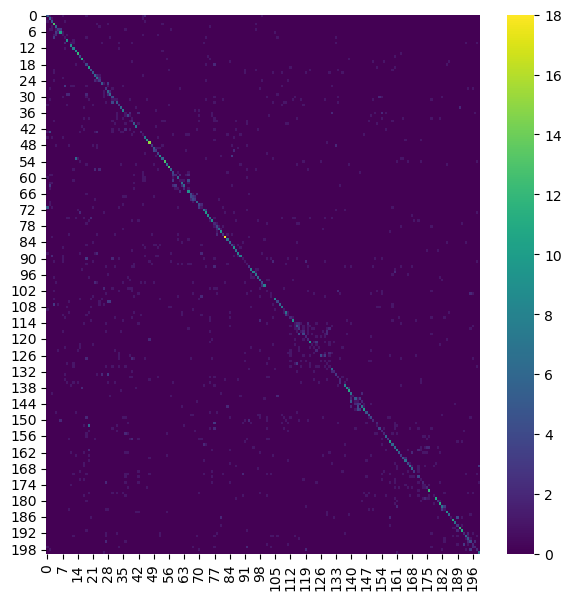

In [14]:
rfc_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(rfc_cm, cmap='viridis')
plt.show()

Many classes are predicted correctly, but there are some off-diagonal values that indicate wrong predictions. They show that some classes are more poorly predicted than others.

### 5 Model Comparisons

In [15]:
#initiate a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

#train and test the KNN model
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

#output test results
test_score_knn = accuracy_score(y_test, knn_y_pred)
train_score_knn = knn.score(X_train, y_train)
print('Testing Accuracy (KNN):', test_score_knn)
print('Training Accuracy (KNN):', train_score_knn)

Testing Accuracy (KNN): 0.32782018659881257
Training Accuracy (KNN): 0.5307529162248145


In [16]:
#initiate a decision tree classifier
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=20)

#train and test the decision tree
dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

#output test results
test_score_dtc = accuracy_score(y_test, dtc_y_pred)
train_score_dtc = dtc.score(X_train, y_train)
print('Testing Accuracy (DTC):', test_score_dtc)
print('Training Accuracy (DTC):', train_score_dtc)

Testing Accuracy (DTC): 0.2553011026293469
Training Accuracy (DTC): 0.995015906680806


<b>Compare the performance of the Random Forest, KNN, and Decision Tree models and
report their accuracies</b><br>
The random forest performed had the highest training accuracy (0.998) and the highest testing accuracy (0.394) out of the three models. It seemed to overfit a little, but not as much as the other models. <br>
The decision tree had a high training accuracy (0.995) but an even lower testing accuracy (0.247) indicating the most overfitting. <br>
The KNN had a lower training accuracy (0.531) but a higher testing accuracy than the decision tree (0.328). <br>
I believe the random forest performed best because it had the highest training and testing accuracies. None of them perform particularly well and aren't too reliable on the testing set on their own.

### 6 Cross-Validation

In [17]:
#initiationg
kf = KFold(n_splits=5, shuffle=True, random_state=7)

#5fold cv on the random forest classifier
rfc_cv_scores = cross_val_score(rfc, X_train, y_train, cv=kf, scoring='accuracy')

#5fold cv on the KNN classifier
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')

#5fold cv on the decision tree classifier
dtc_cv_scores = cross_val_score(dtc, X_train, y_train, cv=kf, scoring='accuracy')

In [20]:
#average accuracy and standard deviation of rfc
print('Average Accuracy (RFC):', np.mean(rfc_cv_scores))
print(f'Standard Deviation (RFC): +/-{np.std(rfc_cv_scores)}')

#average accuracy and standard deviation of knn
print('-------------------------------------------------------')
print('Average Accuracy (KNN):', np.mean(knn_cv_scores))
print(f'Standard Deviation (KNN): +/-{np.std(knn_cv_scores)}')

#average accuracy and standard deviation of dtc
print('-------------------------------------------------------')
print('Average Accuracy (DTC):', np.mean(dtc_cv_scores))
print(f'Standard Deviation (DTC): +/-{np.std(dtc_cv_scores)}')

Average Accuracy (RFC): 0.3780487804878049
Standard Deviation (RFC): +/-0.007565666588223538
-------------------------------------------------------
Average Accuracy (KNN): 0.30869565217391304
Standard Deviation (KNN): +/-0.008760074836930372
-------------------------------------------------------
Average Accuracy (DTC): 0.21940615058324497
Standard Deviation (DTC): +/-0.005704762526537751


### 7 Hyperparameter Tuning

In [21]:
#creating a dictionary of parameters for GridSearchCV
#max_features range: 30 to 50 in steps of 5
#n_estimators range: 100 to 1500 in steps of 10
param_dict = {'max_features': list(range(30, 41, 5)),
              'n_estimators': list(range(100, 151, 10))}

#initating grid search
gs_rfc = GridSearchCV(estimator=rfc,
                      param_grid=param_dict,
                      cv=kf,
                      scoring='accuracy',
                      verbose=True, 
                      n_jobs=2)

#fitting to the train set and getting results
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=RandomForestClassifier(max_features=15, n_estimators=25),
             n_jobs=2,
             param_grid={'max_features': [30, 35, 40],
                         'n_estimators': [100, 110, 120, 130, 140, 150]},
             scoring='accuracy', verbose=True)

In [22]:
#outputting best parameters and results
print(f'The best set of hyperparameters: {gs_rfc.best_params_} with an average cv accuracy of {gs_rfc.best_score_}')
gs_rfc_results = pd.DataFrame(gs_rfc.cv_results_)
gs_rfc_results

The best set of hyperparameters: {'max_features': 30, 'n_estimators': 150} with an average cv accuracy of 0.45609756097560983


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.107568,4.629089,0.306156,0.089087,30,100,"{'max_features': 30, 'n_estimators': 100}",0.447508,0.436373,0.455461,0.442736,0.457052,0.447826,0.007754,15
1,15.493797,1.344050,0.540409,0.033665,30,110,"{'max_features': 30, 'n_estimators': 110}",0.440615,0.444327,0.452280,0.452280,0.458643,0.449629,0.006398,8
2,15.029105,0.650460,0.574578,0.038012,30,120,"{'max_features': 30, 'n_estimators': 120}",0.445387,0.440615,0.454401,0.444857,0.467656,0.450583,0.009646,6
3,15.738078,0.137822,0.537749,0.053914,30,130,"{'max_features': 30, 'n_estimators': 130}",0.435313,0.436373,0.452280,0.448038,0.468187,0.448038,0.012016,13
4,17.000169,0.304309,0.610333,0.071193,30,140,"{'max_features': 30, 'n_estimators': 140}",0.444327,0.446978,0.451750,0.450689,0.468187,0.452386,0.008332,2
5,18.560975,0.392192,0.670402,0.070910,30,150,"{'max_features': 30, 'n_estimators': 150}",0.447508,0.440615,0.465005,0.457052,0.470308,0.456098,0.010915,1
6,13.533299,0.076557,0.386989,0.074029,35,100,"{'max_features': 35, 'n_estimators': 100}",0.441145,0.438494,0.449099,0.436903,0.457582,0.444645,0.007710,17
7,15.104242,0.490852,0.509645,0.056234,35,110,"{'max_features': 35, 'n_estimators': 110}",0.443796,0.434783,0.457052,0.442206,0.462884,0.448144,0.010289,12
8,15.392154,0.376748,0.520635,0.039136,35,120,"{'max_features': 35, 'n_estimators': 120}",0.445387,0.436373,0.452280,0.435313,0.461294,0.446129,0.009803,16
9,16.684587,0.379750,0.530597,0.043141,35,130,"{'max_features': 35, 'n_estimators': 130}",0.441676,0.440085,0.462354,0.449629,0.460764,0.450901,0.009297,5


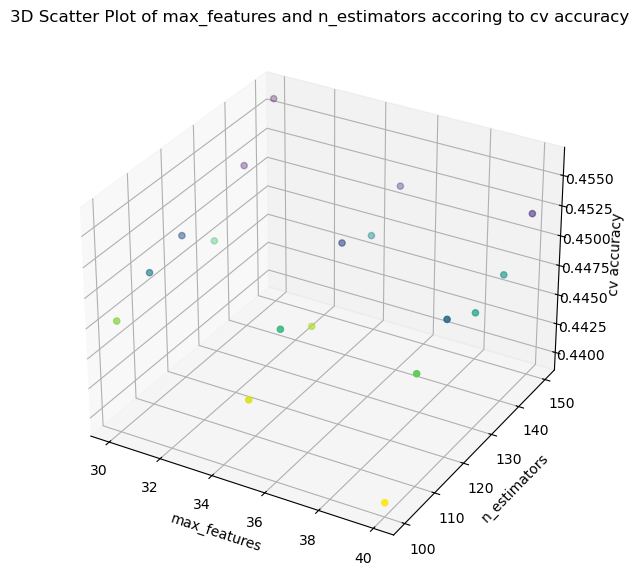

In [23]:
#visualizing results in a 3D scatter plot with 'max_features', 'n_estimators', and 'accuracy' as axes
#setting the figure
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

#setting the axes
ax.scatter3D(gs_rfc_results['param_max_features'],
             gs_rfc_results['param_n_estimators'],
             gs_rfc_results['mean_test_score'],
            c=gs_rfc_results['rank_test_score'])
ax.set_zlabel('cv accuracy')

#plot details
plt.title('3D Scatter Plot of max_features and n_estimators accoring to cv accuracy')
plt.xlabel('max_features')
plt.ylabel('n_estimators')
plt.show()

In [24]:
#retrain rfc with optimized results (max_features=30, n_estimators_150)
rfc2 = gs_rfc.best_estimator_

#fitting on the train set
rfc2.fit(X_train, y_train)

#training and testing accuracies
train_score_rfc2 = rfc2.score(X_train, y_train)
test_score_rfc2 = rfc2.score(X_test, y_test)

print('Training Accuracy of Optimized RFC :', train_score_rfc2)
print('Test Accuracy of Optimized RFC:', test_score_rfc2)


#cv mean accuracy and standard deviation
rfc2_cv_scores = cross_val_score(rfc2, X_train, y_train, cv=kf, scoring='accuracy')
print('Average CV Accuracy:', np.mean(rfc2_cv_scores))
print(f'Standard Deviation: +/-{np.std(rfc2_cv_scores)}')

Training Accuracy of Optimized RFC : 0.9985153764581124
Test Accuracy of Optimized RFC: 0.4758269720101781
Average Accuracy: 0.45577942735949095
Standard Deviation: +/-0.0071342049593018765


The training accuracy of the rfc was increased to 0.999 from 0.998. The testing accuracy was increased from 0.406 to 0.476. The average (cv) accuracy was increased from 0.383 to 0.456. However, the standard deviation increased from 0.007 to 0.009, which isn't necessarily bad, but it does mean more variability.

### 8 Stacking Ensemble

In [26]:
#maive stacking ensemble (cv=None) with base learners not optimized
base_learners = [('en_dtc', DecisionTreeClassifier(criterion='entropy', max_depth=20)), 
                 ('en_knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean')),
                 ('en_svm', SVC(C=1.0, kernel='linear', class_weight=None))]

#meta model rfc with optimized parameters
meta_model = RandomForestClassifier(n_estimators = 150, max_features=30)

#simple/naive stacking classifier
stacking_en = StackingClassifier(estimators=base_learners,
                                 final_estimator=meta_model,
                                 cv=None,
                                 n_jobs=2)
                                 

#train on training data
stacking_en.fit(X_train, y_train)

y_pred_stacking_en = stacking_en.predict(X_test)

In [27]:
#evaluate on test data
test_score_stacking_en = accuracy_score(y_test, y_pred_stacking_en)
print('Test Accuracy of Ensemble:', test_score_stacking_en)


stacking_cv_scores = cross_val_score(stacking_en, X_train, y_train, cv=kf, scoring='accuracy')
print('Average CV Accuracy:', np.mean(stacking_cv_scores))
print(f'Standard Deviation: +/-{np.std(stacking_cv_scores)}')


Test Accuracy of Ensemble: 0.47370653095843934
Average CV Accuracy: 0.4445387062566278
Standard Deviation: +/-0.010962153830710981


Compared to the best model from the previous 3, the rfc (test accuracy=0.476, cv_accuracy=-0.456, std=0.007), this stacking ensemble had a slightly worse test score at 0.474, a worse cv_accuracy of 0.445, and std of 0.011. Overall, the rfc performed better than the stacking ensemble with higher accuracies and less variability.

### 9 Improving Performance

In [41]:
#optimizing base learners
#optimizing dtc
en_svm = SVC()
en_knn = KNeighborsClassifier()

#param dictionaries
svm_param = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [0.2, 0.5, 0.7, 1]}
knn_param = {'n_neighbors': list(range(3, 13, 3)),
             'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine']}

gs_svm = GridSearchCV(estimator=en_svm,
                      param_grid=svm_param,
                      cv=kf,
                      scoring='accuracy',
                      verbose=True, 
                      n_jobs=2)
gs_knn = GridSearchCV(estimator=en_knn,
                      param_grid=knn_param,
                      cv=kf,
                      scoring='accuracy',
                      verbose=True, 
                      n_jobs=2)

#fitting on the training set
gs_svm.fit(X_train, y_train)
gs_knn.fit(X_train, y_train)
           
#outputting best parameters
print(f'The best set of hyperparameters (SVM): {gs_svm.best_params_} with an average cv accuracy of {gs_svm.best_score_}')
print(f'The best set of hyperparameters (KNN): {gs_knn.best_params_} with an average cv accuracy of {gs_knn.best_score_}')

#retraining the dtc with the optimized parameters for later stacking ensemble
svm2 = gs_svm.best_estimator_
knn2 = gs_knn.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best set of hyperparameters (SVM): {'C': 1, 'kernel': 'rbf'} with an average cv accuracy of 0.4691410392364793
The best set of hyperparameters (KNN): {'metric': 'cosine', 'n_neighbors': 12} with an average cv accuracy of 0.348356309650053


In [65]:
#change naive to cv=5 to prevent overfitting
#change base learners to optimized base learners
#change dtc to xgb for more diveristy of complex and simple learners for generalization
base_learners = [('en_xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42,
                                         objective='multi.softmax', eval_metric='merror')), 
                 ('en_knn', knn),
                 ('en_svm', svm2)]

#meta model rfc with optimized parameters
meta_model = RandomForestClassifier(n_estimators = 150, max_features=30)

#cv stacking classifier
stacking_en2 = StackingClassifier(estimators=base_learners,
                                 final_estimator=meta_model,
                                 cv=5,
                                 n_jobs=2)
                                 

#train on training data
stacking_en2.fit(X_train, y_train)

y_pred_stacking_en2 = stacking_en2.predict(X_test)

In [67]:
#evaluate on test data
test_score_stacking_en2 = accuracy_score(y_test, y_pred_stacking_en2)
print('Test Accuracy of Optimized Ensemble:', test_score_stacking_en2)

stacking_cv_scores2 = cross_val_score(stacking_en2, X_train, y_train, cv=kf, scoring='accuracy')
print('Average CV Accuracy:', np.mean(stacking_cv_scores2))
print(f'Standard Deviation: +/-{np.std(stacking_cv_scores2)}')


Test Accuracy of Optimized Ensemble: 0.4957591178965225
Average CV Accuracy: 0.4715800636267232
Standard Deviation: +/-0.013234766287866549


<b> Model Improvement Discussion </b> <br>
The very first step I used in creating a better ensemble was implementing out-of-fold predictions with cv=5 to avoid the overfitting problem of the other models. Next, I optimized my base learners with GridSearchCV to generate better predictions for the meta model. I decided to change a base learner from a dt classifier to xgb classifier. Even though xgb classifiers are ensembles mostly used as meta-models, I found that introducing a more complex model alongside the simple knn model in the base learners introduced a diversity which resulted in better generalization. I chose it for its multi-class classification capabilities and ability to work with larger datasets. I tried using it as a meta-model and, in turn, used the optimized rfc as a base learner, but it had a slightly worse performance so I kept it as a base learner. For further improvements, I could have optimized the xgb classifier with GridSearchCV like the other base learners. <br>
In the end, I got a Test Ensemble Accuracy of 0.496. The most current model wasn't able to run due to computation limitations, but previous CVs were around 0.467 with a standard deviation of 0.01 making it overall better than the previous ensemble.